In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import seaborn as sns
import pandas as pd
from pathlib import Path
from evaluation.cross_tool_analysis import (
    load_proverbot,
    load_tactician,
    load_human,
    load_rango,
    get_unique_files,
    get_mutual_proof_pairs,
    NamedEval,
    get_two_eval_subsets,
    SuccessfulResult,
    GeneralResult,
    get_mutually_successful_proof_pairs,
    proof_length,
    fair_edist,
)

In [2]:
if Path(os.curdir).resolve().name == "evaluation":
    os.chdir("../..")
elif Path(os.curdir).resolve().name == "coq-modeling":
    pass
else:
    raise ValueError(f"In an unexpected directory: {os.curdir}")

In [3]:
#PROVERBOT_LOC = Path("evaluations/proverbot")
PROVERBOT_LOC = Path("/work/pi_brun_umass_edu/asanchezster/proverbot9001/rango-test-set-report")
TACTICIAN_LOC = Path("evaluations/tactician/results-24-07-22")
# GRAPH2TAC_LOC = Path("evaluations/graph2tac/results-2024-07-29")
RANGO_LOC = Path("evaluations/eval-results-old/deepseek-proof-prem-final")
#HUMAN_LOC = Path("evaluations/human")
# RANGO_LOC = Path("evaluations/eval-results/deepseek-proof-prem-final-test-500")
# RANGO_LOC = Path("evaluations/eval-results/deepseek-proof-final-test-500")

In [4]:
proverbot_eval = NamedEval("proverbot", load_proverbot(PROVERBOT_LOC))
tactician_eval = NamedEval("tactician", load_tactician(TACTICIAN_LOC))
#graph2tac_eval = NamedEval("graph2tac", load_tactician(GRAPH2TAC_LOC))
#human_eval = NamedEval("human", load_human(HUMAN_LOC))
rango_eval = NamedEval("rango", load_rango(RANGO_LOC))

In [5]:
# rango_eval = NamedEval("rango", load_rango(RANGO_LOC))

In [6]:
raw_evals = [
    proverbot_eval,
    rango_eval,
   tactician_eval,
    # human_eval,
    # proverbot_eval,
    # graph2tac_eval,
]

In [7]:
[len(e.results) for e in raw_evals]

[11718, 12007]

In [8]:
PROJECTS = [
    "CompCert",
    "coq-ext-lib",
    "fourcolor",
    "math-classes",
    "reglang",
    "buchberger",
    "hoare-tut",
    "zorns-lemma",
    "huffman",
    "PolTac",
    "dblib",
    "zfc",
]
project_evals = [e.filter_projects(PROJECTS) for e in raw_evals]
mutual_proofs = get_mutual_proof_pairs(project_evals)
evals = [e.filter_results(mutual_proofs) for e in raw_evals]
assert all(len(e.results) == len(mutual_proofs) for e in evals)

## Overall Results

In [9]:
[len(e.results) for e in evals]

[9942, 9942]

In [19]:
def attempts_by_project(e: NamedEval) -> dict[str, list[GeneralResult]]:
    grouped_results: dict[str, list[GeneralResult]] = {}
    for r in e.results:
        project = r.file.parts[0]
        if project not in grouped_results:
            grouped_results[project] = []
        grouped_results[project].append(r)
    return grouped_results


def count_successes(results: list[GeneralResult]) -> int:
    return sum(1 for r in results if r.success)


rows: list[tuple[str, str, int, int, float, str]] = []
#for e in raw_evals:
for e in evals:
    attempts_by_proj = attempts_by_project(e)
    for proj, attempts in attempts_by_project(e).items():
        n_successes = len(NamedEval("foo", attempts).get_successful_results())
        n_attempts = len(attempts)
        p = n_successes / n_attempts
        p_str = f"{p:.3f} ({n_successes}/{n_attempts})"
        rows.append((e.name, proj, n_successes, n_attempts, p, p_str))

total_df = pd.DataFrame(
    rows,
    columns=[
        "System",
        "Project",
        "Successes",
        "Attempts",
        "Success Rate [f]",
        "Success Rate",
    ],
)
total_df.groupby("System").agg({"Successes": "sum", "Attempts": "sum"}).assign(
    SuccessRate=lambda df: df["Successes"] / df["Attempts"]
)

,Successes,Attempts,SuccessRate
System,,,
proverbot,1856,9942,0.186683
rango,2788,9942,0.280426


In [18]:
system_cols = (
    total_df.set_index(["Project", "System"])["Success Rate"].unstack().dropna()
)
system_cols

System,proverbot,rango
Project,,
CompCert,0.221 (1416/6420),0.284 (1839/6476)
PolTac,0.493 (67/136),0.796 (246/309)
buchberger,0.157 (103/657),0.214 (141/658)
coq-ext-lib,0.201 (45/224),0.533 (121/227)
dblib,0.311 (60/193),0.557 (113/203)
fourcolor,0.094 (138/1471),0.154 (222/1445)
hoare-tut,0.368 (7/19),0.222 (2/9)
huffman,0.174 (47/270),0.233 (63/270)
math-classes,0.152 (259/1703),0.331 (497/1501)


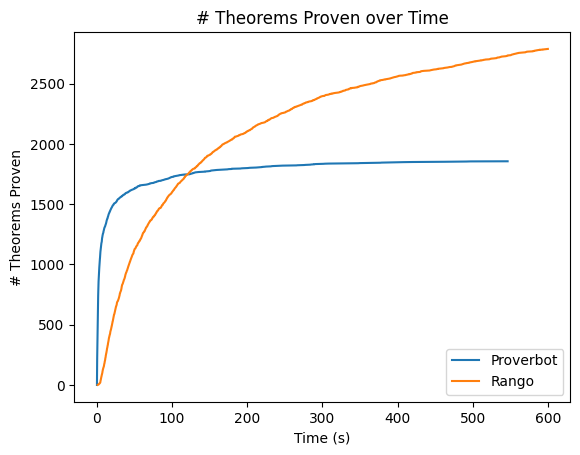

In [12]:
def plot_times(es: list[NamedEval]):
    times = [e.get_time_points() for e in es]
    fig, ax = plt.subplots()
    for e, time_list in zip(es, times):
        xs = [t.x for t in time_list]
        ys = [t.y for t in time_list]
        ax.plot(xs, ys, label=e.name.title())
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("# Theorems Proven")
    ax.set_title("# Theorems Proven over Time")
    ax.legend(loc="lower right")


plot_times(evals)

Total # Found =  3278


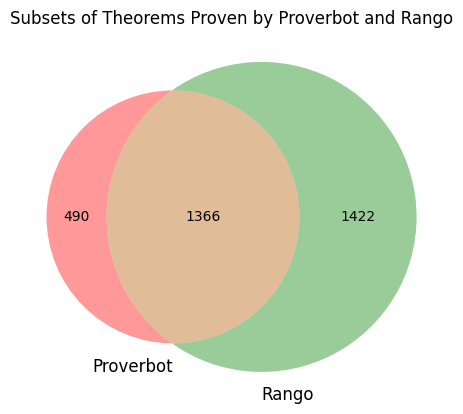

In [13]:
def compare_two(es: list[NamedEval], e1_alias: str, e2_alias: str) -> int:
    fig, ax = plt.subplots()
    subsets = get_two_eval_subsets(es, e1_alias, e2_alias)
    venn2(
        (len(subsets.one_only), len(subsets.two_only), len(subsets.one_two)),
        set_labels=(e1_alias.title(), e2_alias.title()),
        ax=ax,
    )
    ax.set_title(
        f"Subsets of Theorems Proven by {e1_alias.title()} and {e2_alias.title()}"
    )
    get_two_eval_subsets(es, e1_alias, e2_alias)
    return len(subsets.one_only) + len(subsets.one_two) + len(subsets.two_only)


total_found = compare_two(evals, evals[0].name, evals[1].name)
print("Total # Found = ", total_found)

In [14]:
from evaluation.cross_tool_analysis import ProofPair

len(set([ProofPair(s.file, s.theorem) for s in evals[0].get_successful_results()]))

1856

In [15]:
subsets = get_two_eval_subsets(evals, "tactician", "rango")

AssertionError: 

In [ ]:
import json

with open("tactician_only.json", "w") as fout:
    fout.write(
        json.dumps(
            [{"file": str(s.file), "theorem": s.theorem} for s in subsets.one_only],
            indent=2,
        )
    )

## Proof Length & Similarity

In [ ]:
successes = get_mutually_successful_proof_pairs(raw_evals)
print("Mutually successful: ", len(successes["rango"]))

Mutually successful:  1895


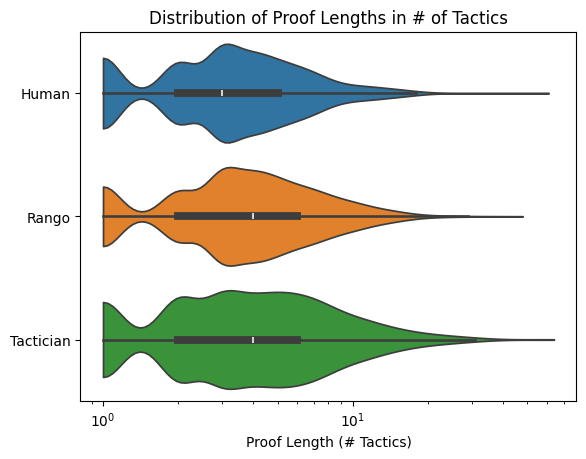

In [ ]:
import seaborn as sns


keys = ["human", "rango", "tactician"]
proof_lengths = pd.DataFrame(
    dict([(k.title(), [proof_length(s.proof) for s in successes[k]]) for k in keys])
)
proof_lengths.to_csv("proof-length-df.csv")
fig, ax = plt.subplots()
sns.violinplot(
    proof_lengths,
    orient="h",
    ax=ax,
    log_scale=True,
    cut=0,
)
ax.set_title("Distribution of Proof Lengths in # of Tactics")
ax.set_xlabel("Proof Length (# Tactics)")
fig.savefig("proof-length-violin.png")

In [ ]:
proof_lengths.mean()

Human        3.881794
Rango        4.413720
Tactician    5.072823
dtype: float64

In [ ]:
proof_lengths.median()

Human        3.0
Rango        4.0
Tactician    4.0
dtype: float64

In [ ]:
short_tactician_pairs = [
    (p.proof, h.proof)
    for p, h in zip(successes["tactician"], successes["human"])
    if proof_length(p.proof) < proof_length(h.proof)
]
import random

random.seed(0)
short_tactician_sample = random.sample(short_tactician_pairs, 100)
for s, h in short_tactician_sample:
    print("Tactician: ", (proof_length(s)))
    print(s)
    print()
    print("Human: ", (proof_length(h)))
    print(h)
    print("===========================")

Tactician:  2
intros; apply H

Human:  3

Proof.
intros.
unfold eval.
apply H.
Qed.
Tactician:  5
intros a b H' H'0; elim ppc_is_ppcm; auto; auto; auto

Human:  12

Proof using plusA minusA invA cs.
intros a b H' H'0; try assumption.
lapply (ppc_is_ppcm a b);
 [ intros H'3; lapply H'3; clear H'3; [ intros H'4 | idtac ] | idtac ]; 
 auto; auto.
inversion H'4; auto.
Qed.
Tactician:  4
intros; generalize (Zlt_is_lt_bool x y); intros (H1, H2); lia

Human:  5

Proof.
intros x y.
case Zle_bool_spec ; intros H.
now rewrite Zlt_bool_false.
now rewrite Zlt_bool_true.
Qed.
Tactician:  3
eauto; intros; eauto

Human:  17

Proof.
  induction 1; intros; simpl; auto with arith.
  exploit leftcontextlist_size; eauto. auto with arith.
  exploit leftcontextlist_size; eauto. auto with arith.
  induction 1; intros; simpl; auto with arith. exploit leftcontext_size; eauto. auto with arith.
Qed.
Tactician:  6
unfold agree_regs; split; intros; auto; intros; eauto

Human:  7

Proof.
  intros; split; intros. re

<Axes: >

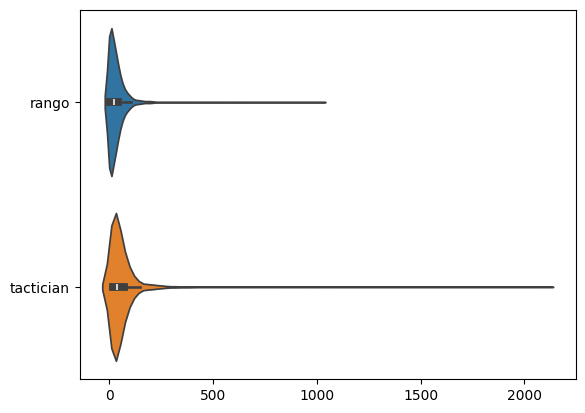

In [ ]:
human_proofs = [s.proof for s in successes["human"]]
rango_proofs = [s.proof for s in successes["rango"]]
tactician_proofs = [s.proof for s in successes["tactician"]]
rango_edists = [
    fair_edist(human_proof, s.proof)
    for s, human_proof in zip(successes["rango"], human_proofs)
]
tactician_edists = [
    fair_edist(human_proof, s.proof)
    for s, human_proof in zip(successes["tactician"], human_proofs)
]
edist_df = pd.DataFrame(dict(rango=rango_edists, tactician=tactician_edists))
edist_df["rango"] = edist_df["rango"].astype(float)
edist_df["tactician"] = edist_df["tactician"].astype(float)
fig, ax = plt.subplots()
sns.violinplot(edist_df, orient="h", ax=ax)

In [ ]:
edist_df.mean()

rango        33.113984
tactician    56.632718
dtype: float64

In [ ]:
edist_df.median()

rango        21.0
tactician    39.0
dtype: float64

## Proof Rates by Ground Truth Length

In [ ]:
ranges = [
    (1, 4),
    (5, 8),
    (9, 12),
    (13, 16),
    (17, 20),
    (21, None),
]

range_sets = [human_eval.get_successful_proofs_in_range(*r) for r in ranges]
mutual_range_sets = [mutual_proofs & r for r in range_sets]
dfs: list[pd.DataFrame] = []
df_names: list[str] = []
index_strs = [f"{r[0]}-{r[1]}" for r in ranges]
index_strs[-1] = f"{ranges[-1][0]}+"

for eval in evals:
    if eval.name == "human":
        continue
    rows: list[tuple[int, int, float]] = []
    columns = ["successes", "attempts", "success_rate"]
    for range_set in mutual_range_sets:
        range_results = eval.filter_results(range_set)
        successes = len(range_results.get_successful_results())
        attempts = len(range_results.results)
        success_rate = 100 * successes / attempts
        rows.append((successes, attempts, success_rate))
    df = pd.DataFrame(rows, columns=columns, index=index_strs)
    dfs.append(df)
    df_names.append(eval.name.title())

for df, name in zip(dfs, df_names):
    print(name)
    print(df)
    print()

Rango
       successes  attempts  success_rate
1-4         1919      3670     52.288828
5-8          719      2366     30.388842
9-12         161      1235     13.036437
13-16         60       750      8.000000
17-20         18       551      3.266788
21+           17      1831      0.928454

Tactician
       successes  attempts  success_rate
1-4         1643      3670     44.768392
5-8          691      2366     29.205410
9-12         158      1235     12.793522
13-16         68       750      9.066667
17-20         28       551      5.081670
21+           25      1831      1.365374



In [ ]:
assert 0 < len(dfs)
merged = dfs[0][["success_rate"]]
merged.columns = [df_names[0]]
for df in dfs[1:]:
    merged = merged.merge(df[["success_rate"]], left_index=True, right_index=True)
    merged.columns = df_names[: len(merged.columns)]
merged

,Rango,Tactician
1-4,52.288828,44.768392
5-8,30.388842,29.205410
9-12,13.036437,12.793522
13-16,8.000000,9.066667
17-20,3.266788,5.081670
21+,0.928454,1.365374


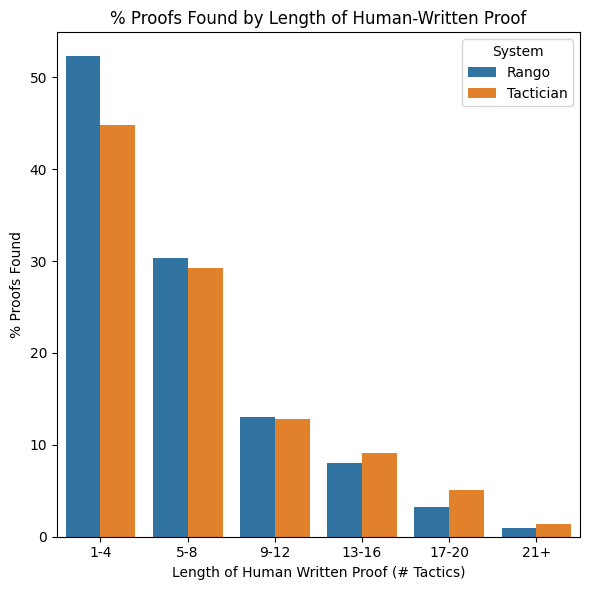

In [ ]:
# Reset the index to use it as a column for Seaborn
plot_df = merged.reset_index().melt(
    id_vars=["index"], var_name="Evaluation", value_name="Success Rate"
)

# Rename the 'index' column to 'Range'
plot_df = plot_df.rename(columns={"index": "Range"})

# Plot the bar chart
plt.figure(figsize=(6, 6))
sns.barplot(x="Range", y="Success Rate", hue="Evaluation", data=plot_df)
plt.xlabel("Length of Human Written Proof (# Tactics)")
plt.ylabel("% Theorems Proven")
plt.title("% Theorems Proven by Length of Human-Written Proof")
plt.xticks()
plt.legend(title="System")
plt.tight_layout()
plt.show()

## Proof Rates by Number of Dependencies

In [ ]:
ranges = [
    # (1, 100),
    # (101, 200),
    # (201, 300),
    # (301, 400),
    # (400, None),
    (1, 50),
    (51, 100),
    (101, 150),
    (151, 200),
    (201, 250),
    (251, None),
    # (251, 300),
    # (301, None)
]
project = False

# ranges = [
#     (1, 15),
#     (16, 30),
#     (31, 45),
#     (46, 60),
#     (61, None),
# ]
# project=True


range_sets = [human_eval.get_proofs_in_dep_range(*r, proj=project) for r in ranges]
mutual_range_sets = [mutual_proofs & r for r in range_sets]
dfs: list[pd.DataFrame] = []
df_names: list[str] = []
index_strs = [f"{r[0]}-{r[1]}" for r in ranges]
index_strs[-1] = f"{ranges[-1][0]}+"

for eval in evals:
    if eval.name == "human":
        continue
    rows: list[tuple[int, int, float]] = []
    columns = ["successes", "attempts", "success_rate"]
    for range_set in mutual_range_sets:
        range_results = eval.filter_results(range_set)
        successes = len(range_results.get_successful_results())
        attempts = len(range_results.results)
        success_rate = 100 * successes / attempts
        rows.append((successes, attempts, success_rate))
    df = pd.DataFrame(rows, columns=columns, index=index_strs)
    dfs.append(df)
    df_names.append(eval.name.title())

for df, name in zip(dfs, df_names):
    print(name)
    print(df)
    print()

Rango
         successes  attempts  success_rate
1-50           142       353     40.226629
51-100         166       387     42.894057
101-150        468      2191     21.360110
151-200        837      2677     31.266343
201-250         41       166     24.698795
251+          1199      4540     26.409692

Tactician
         successes  attempts  success_rate
1-50           160       353     45.325779
51-100         182       387     47.028424
101-150        354      2191     16.157006
151-200        736      2677     27.493463
201-250         39       166     23.493976
251+          1108      4540     24.405286



In [ ]:
assert 0 < len(dfs)
merged = dfs[0][["success_rate"]]
merged.columns = [df_names[0]]
for df in dfs[1:]:
    merged = merged.merge(df[["success_rate"]], left_index=True, right_index=True)
    merged.columns = df_names[: len(merged.columns)]
merged

,Rango,Tactician
1-50,40.226629,45.325779
51-100,42.894057,47.028424
101-150,21.360110,16.157006
151-200,31.266343,27.493463
201-250,24.698795,23.493976
251+,26.409692,24.405286


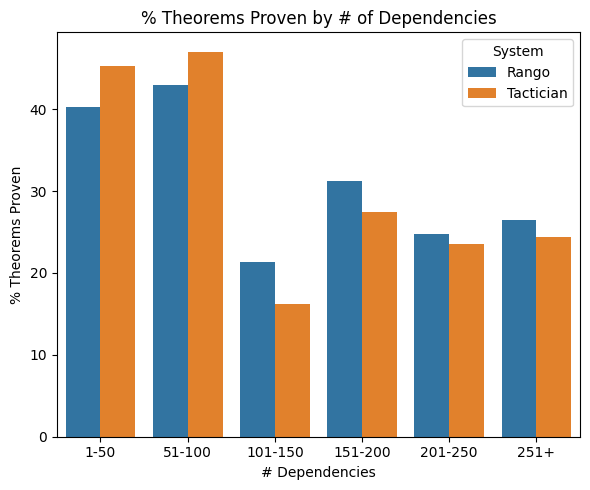

In [ ]:
# Reset the index to use it as a column for Seaborn
plot_df = merged.reset_index().melt(
    id_vars=["index"], var_name="Evaluation", value_name="Success Rate"
)

# Rename the 'index' column to 'Range'
plot_df = plot_df.rename(columns={"index": "Range"})

if project:
    title = "% Theorems Proven by # In-Project Dependencies"
    x_lab = "# In-Project Dependencies"
else:
    title = "% Theorems Proven by # of Dependencies"
    x_lab = "# Dependencies"

# Plot the bar chart
plt.figure(figsize=(6, 5))
sns.barplot(x="Range", y="Success Rate", hue="Evaluation", data=plot_df)
plt.xlabel(x_lab)
plt.ylabel("% Theorems Proven")
plt.title(title)
plt.xticks()
plt.legend(title="System")
plt.tight_layout()
plt.show()

## Examples

In [ ]:
filtered_rango = rango_eval.filter_results(mutual_proofs)
filtered_tactician = tactician_eval.filter_results(mutual_proofs)

sorted_rango = sorted(filtered_rango.results)
sorted_tactician = sorted(filtered_tactician.results)

print(sorted_rango[3392])
print(sorted_tactician[3392])

example_str = ""

for r, t in zip(sorted_rango, sorted_tactician):
    if r.success and not t.success:
        assert r.proof is not None
        example_str += (
            f"{r.file}\n"
            f"{r.theorem + r.proof}\n"
            "--------------------------------------"
            "--------------------------------------"
        )

with open("evaluations/stuff/examples.txt", "w") as fout:
    fout.write(example_str)

GeneralResult(file=PosixPath('CompCert/Raux.v'), raw_file=PosixPath('repos/AbsInt-CompCert/flocq/Core/Raux.v'), theorem='Theorem Rmult_min_distr_r : forall r r1 r2 : R, (0 <= r)%R -> (Rmin r1 r2 * r)%R = Rmin (r1 * r) (r2 * r).', time=622.8097562789917, success=False, proof=None, num_deps=None, num_proj_deps=None)
GeneralResult(file=PosixPath('CompCert/Raux.v'), raw_file=PosixPath('repos/AbsInt-CompCert/flocq/Core/Raux.v'), theorem='Theorem Rmult_min_distr_r : forall r r1 r2 : R, (0 <= r)%R -> (Rmin r1 r2 * r)%R = Rmin (r1 * r) (r2 * r).', time=600.1504991054535, success=False, proof=None, num_deps=None, num_proj_deps=None)
CompCert/AST.v
Lemma prog_defmap_norepet: forall id g, list_norepet (prog_defs_names p) -> In (id, g) (prog_defs p) -> (prog_defmap p)!id = Some g.
Proof.
  apply PTree_Properties.of_list_norepet; auto.
--------------
CompCert/AST.v
Lemma prog_defmap_unique: forall defs1 id g defs2, prog_defs p = defs1 ++ (id, g) :: defs2 -> ~In id (map fst defs2) -> (prog_defmap p)